## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Лыжин Роман Денисович

In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [62]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 68.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 45.4MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 35.1MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.81MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [63]:
images_train, labels_train = next(iter(train_loader))

In [64]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

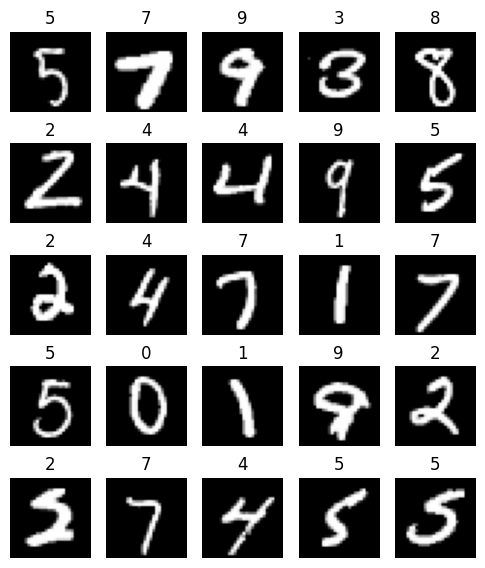

In [65]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [66]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [67]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [68]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

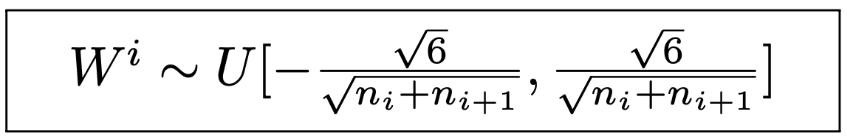

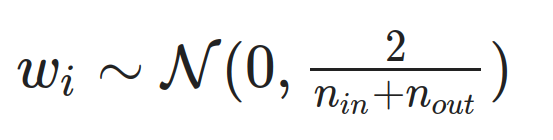

In [69]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0.0, 2 / (784 + 500))
init_layer(layer_2, 0.0, 2 / (500 + 10))

Используем Tanh в качестве функции активации:

In [ ]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0103775262832642
forward 0.043561723083257675
backward 0.026666665449738503
backward 0.0012417871039360762


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

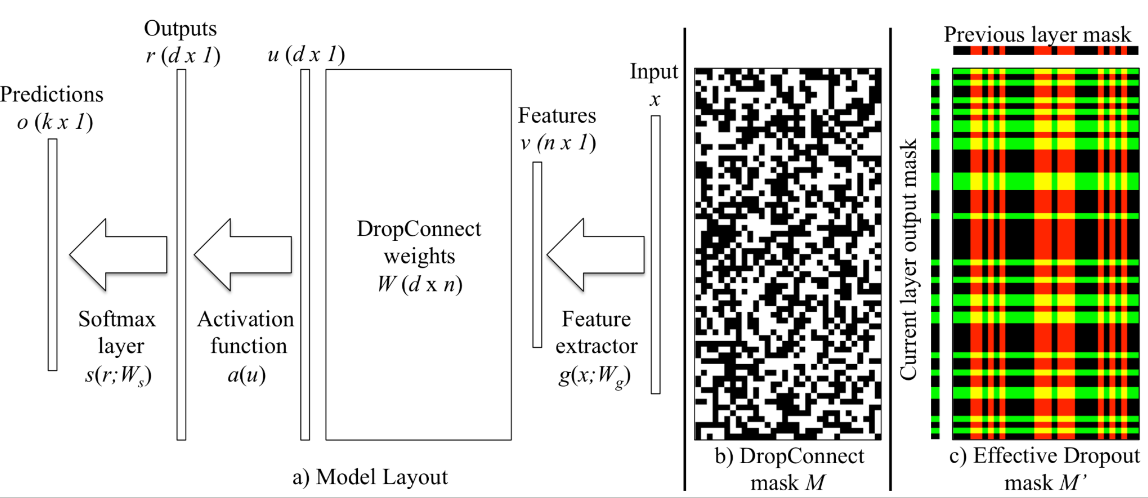

In [101]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = self.linear.weight.detach().clone()
            mask.bernoulli_(1 - self.p)
        else:
            mask = 1 - self.p

        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [86]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        mask = mask.to(x.device)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = 1 - self.p

        return x * mask

Основа для сети, которую будем обучать:

In [82]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [72]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

In [73]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [74]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302959
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.403223
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.243893
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.282636
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.152613
Test Epoch: 0	Loss: 0.177745
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.262823
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.136413
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.109052
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.130265
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.055129
Test Epoch: 1	Loss: 0.118809
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.179025
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.045456
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.087194
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.100812
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.097279
Test Epoch: 2	Loss: 0.088474
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.073986
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.087141
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.042721
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [96]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import clear_output
%matplotlib inline

def train(network, train_loader, test_loader, epochs, optimizer, loss_fn, plot=True, verbose=True):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(epochs):
            network.train()
            train_losses = []
            train_accuracies = []

            for X, y in train_loader:
                optimizer.zero_grad()
                prediction = network(X)
                loss_batch = loss_fn(prediction, y)
                train_losses.append(loss_batch.item())

                loss_batch.backward()
                optimizer.step()

                _, predicted_labels = torch.max(prediction, 1)
                accuracy = (predicted_labels == y).float().mean().item()
                train_accuracies.append(accuracy)

            train_loss_epochs.append(sum(train_losses) / len(train_losses))
            train_accuracy_epochs.append(sum(train_accuracies) / len(train_accuracies))

            network.eval()
            test_losses = []
            test_accuracies = []

            with torch.no_grad():
                for X, y in test_loader:
                    prediction = network(X)
                    loss_batch = loss_fn(prediction, y)
                    test_losses.append(loss_batch.item())

                    _, predicted_labels = torch.max(prediction, 1)
                    accuracy = (predicted_labels == y).float().mean().item()
                    test_accuracies.append(accuracy)

            test_loss_epochs.append(sum(test_losses) / len(test_losses))
            test_accuracy_epochs.append(sum(test_accuracies) / len(test_accuracies))
            clear_output(True)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}... "
                      f"(Train/Test) NLL: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f} "
                      f"Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}")

            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                plt.pause(0.1)

    except KeyboardInterrupt:
        pass

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [97]:
layers_with_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

Epoch 10/10... (Train/Test) NLL: 0.085/0.053 Accuracy: 0.974/0.981


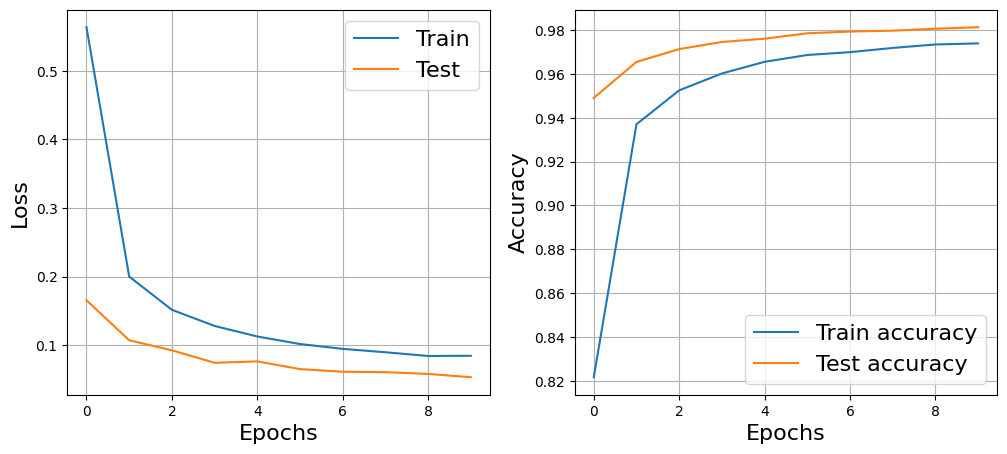

([0.563544539468629,
  0.20016829159531765,
  0.15174205992013406,
  0.12819354352094472,
  0.11284887106386202,
  0.10185695514638922,
  0.09479326401342715,
  0.08986402012860534,
  0.08442261678450652,
  0.08471793569187556],
 [0.1657037679341775,
  0.10732029956069929,
  0.09272650016259544,
  0.07448635225868018,
  0.07656113143208661,
  0.06533018157145457,
  0.06146077626632362,
  0.060859161160909864,
  0.05832665308696937,
  0.053482988669501644],
 [0.8216673330203302,
  0.9370502398720683,
  0.9525086620469083,
  0.9602045575692963,
  0.9655294953378787,
  0.968638948158923,
  0.9699382551951703,
  0.9718594526939555,
  0.9734474946695096,
  0.9739305703624733],
 [0.9490704113924051,
  0.9654865506329114,
  0.9713212025316456,
  0.9745846518987342,
  0.9760680379746836,
  0.9785403481012658,
  0.9793314873417721,
  0.9797270569620253,
  0.9806170886075949,
  0.981309335443038])

In [98]:
network = TestNetwork(nn.Sequential(*layers_with_dropout))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train(network, train_loader, test_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn)

In [102]:
layers_with_dropconnect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10),
]

Epoch 10/10... (Train/Test) NLL: 0.156/0.079 Accuracy: 0.953/0.974


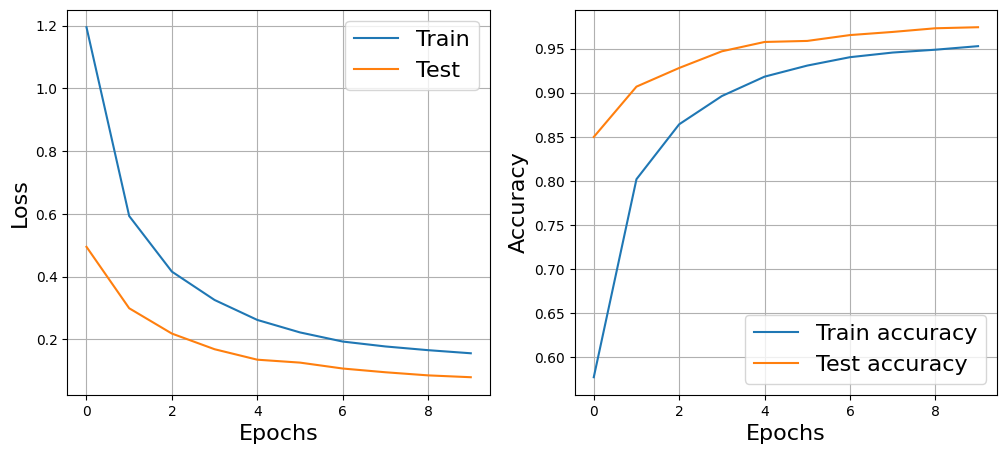

([1.1947239141728578,
  0.5930318714840326,
  0.415855190138827,
  0.32549977741007613,
  0.2619632983735121,
  0.22214382774095293,
  0.19306520573588323,
  0.1774201748976067,
  0.1655798170930033,
  0.15569910596110928],
 [0.49485804913919185,
  0.29913400830347325,
  0.21842903474086448,
  0.16857946720681613,
  0.1352296585240696,
  0.12593693903918507,
  0.10710898325837488,
  0.09518392299172244,
  0.08525783793788545,
  0.07937369152573467],
 [0.5774808991184113,
  0.8019389658848614,
  0.8641557835820896,
  0.89617759421436,
  0.9181603144989339,
  0.9307147298794566,
  0.9402263236960877,
  0.9454790778251599,
  0.9486995824872811,
  0.9527252132196162],
 [0.8497824367088608,
  0.9068433544303798,
  0.928006329113924,
  0.9468947784810127,
  0.9574762658227848,
  0.9586629746835443,
  0.9652887658227848,
  0.9688488924050633,
  0.9730023734177216,
  0.974189082278481])

In [103]:
network = TestNetwork(nn.Sequential(*layers_with_dropconnect))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train(network, train_loader, test_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn)

Dropout и DropConnect помогают предотвращать переобучение. В данном случае Dropout оказался чуть более эффективным.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

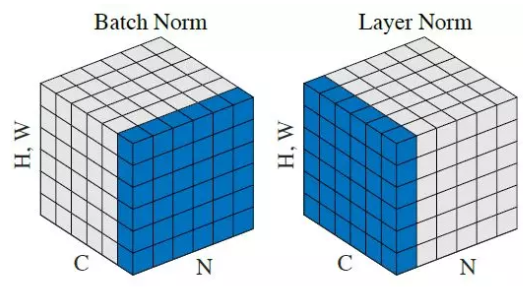

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [106]:
import torch
import torch.nn as nn

class LayerNormalization(nn.Module):
    def __init__(self, features_dim, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(features_dim))
        self.beta = nn.Parameter(torch.zeros(features_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)

        x_normalized = (x - mean) / (std + self.eps)
        output = self.gamma * x_normalized + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [104]:
layers_with_batch_norm = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

Epoch 10/10... (Train/Test) NLL: 0.017/0.063 Accuracy: 0.994/0.983


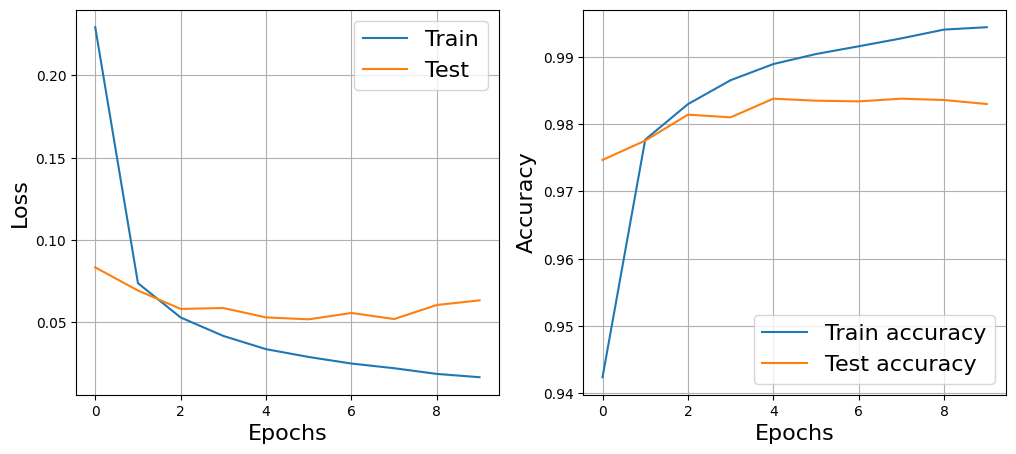

([0.22934347874860264,
  0.07374628535164063,
  0.052880663166084745,
  0.04165747398629721,
  0.03361625295740042,
  0.028864707253170387,
  0.024871460747903088,
  0.02202880757027812,
  0.01856590306219051,
  0.01655798013667578],
 [0.08332983989127074,
  0.0692736923199477,
  0.05808159162561539,
  0.058632034106958136,
  0.05292479099434671,
  0.0517536172756772,
  0.05561838554265567,
  0.05193416061044871,
  0.06047548696434102,
  0.06328892260841448],
 [0.9424084932056825,
  0.9776952292110874,
  0.9829701936321218,
  0.9865294065810978,
  0.9889225746268657,
  0.99041622241677,
  0.9915656094103734,
  0.9927427594595627,
  0.9940476190052561,
  0.994397432438092],
 [0.9746835443037974,
  0.9775514240506329,
  0.9814082278481012,
  0.9810126582278481,
  0.9837816455696202,
  0.9834849683544303,
  0.9833860759493671,
  0.9837816455696202,
  0.9835838607594937,
  0.9829905063291139])

In [105]:
network = TestNetwork(nn.Sequential(*layers_with_batch_norm))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train(network, train_loader, test_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn)

In [107]:
layers_with_layer_norm = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

Epoch 10/10... (Train/Test) NLL: 0.024/0.064 Accuracy: 0.992/0.982


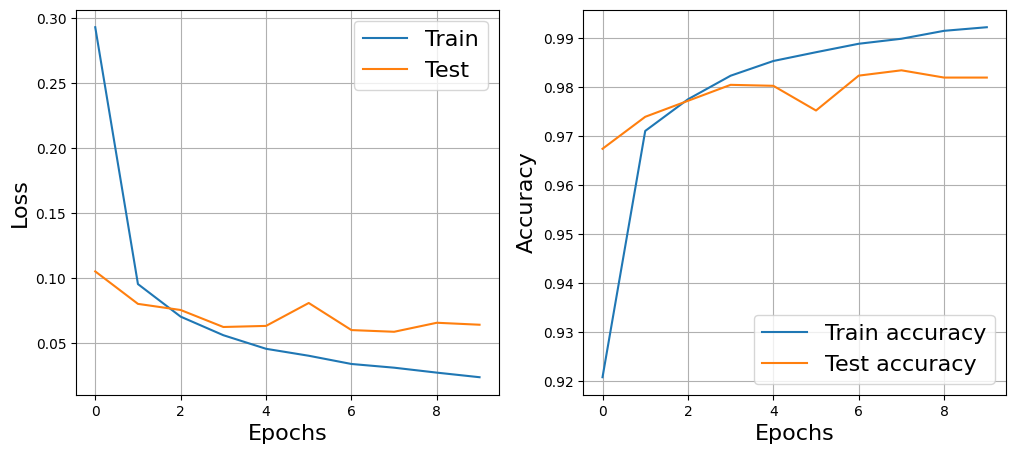

([0.2928575037448391,
  0.09522561293873769,
  0.07017996420126671,
  0.05589285257187034,
  0.0454384959759568,
  0.04008803515087392,
  0.03375485544003594,
  0.030897986882531057,
  0.027098479167025076,
  0.02356681307114518],
 [0.10498205006499833,
  0.0799991081032572,
  0.07529218360498736,
  0.062214277637533,
  0.06305017958312661,
  0.08067756180380341,
  0.05983479039248409,
  0.05853227643727891,
  0.06547256614320286,
  0.06395128421497213],
 [0.9207256130063965,
  0.9710043532761938,
  0.9774620202558635,
  0.98228167203952,
  0.9852856254018446,
  0.9870791134041256,
  0.9888059701492538,
  0.9898276475192641,
  0.9914490049327614,
  0.9921819473634651],
 [0.9673655063291139,
  0.9738924050632911,
  0.9771558544303798,
  0.9804193037974683,
  0.9802215189873418,
  0.9751780063291139,
  0.9822982594936709,
  0.9833860759493671,
  0.9819026898734177,
  0.9819026898734177])

In [108]:
network = TestNetwork(nn.Sequential(*layers_with_layer_norm))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train(network, train_loader, test_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn)

BatchNorm и LayerNorm имеют сопоставимые результаты, однако BatchNorm оказался чуть более эффективным.